# Data, classification task

Our data will be a set of articles downloaded from Wikipedia that we need to classify as concerning 'Medical' topics, or 'Non medical'; in particular, we need to classify documents in two classes: those with a 'Medical' tags, and those without it.

## Data retrieval

To create a dataset that can be used for the classification task we need to download articles from Wikipedia API. Wikipedia already groups articles under different categories, so for this binary classification task we can just use their functions to select a category and then download articles belonging to that category.

Wikipedia categories are highly hierarchical, so, for e.g., the category 'Medicine' contains few articles and many subcategories, which are themselves articles; these in turn contains many other subcategories and so on.
To 'fix' the search I did some exploratory analysis of the available categories to determine which had enouigh articles to build a decently-sized dataset. 

For the medical catogories, I went with the following categories:

In [1]:
medical_categories = [
    "Category:Alternative medicine stubs",
    "Category:Evidence-based medicine",
    "Category:Veterinary medicine stubs",
    "Category:Vaccination",
    "Category:2018 disease outbreaks",
]

For the non-medical categories, I went with scientific and non-scientific categories. I did explicity add scientific/related categories to make the classification task more interesting: i expect an article belonging to the 'Literature' to be classified correctly quite easily; an article belonging to 'Geology' or 'AI', a bit less (due to possible overlapping topics).  

In [2]:
non_medical_categories = [
    "Category:Dark ages",
    "Category:Historiography of China",
    "Category:Sports controversies",
    "Category:Philosophy of artificial intelligence",
    "Category:Geology",
    "Category:Space",
    "Category:Literature",
    "Category:Music videos",
]

We use these categories to download the articles's *ids* using the function

In [6]:
import requests


# "url": url of the API; "categories": categories from which we want to extract (aggregate) ids
# "force_download": if True, download them from the API; do nothing otherwise
def get_ids(url, categories, force_download=False):
    if not force_download:
        print(" ! Returned empty ids because force_download was set to False !")
        return []

    returned_ids = []

    for c in categories:
        params = {
            "action": "query",
            "cmtitle": c,
            "cmlimit": "500",
            # "cmtype": "subcat",
            "list": "categorymembers",
            "format": "json",
        }

        req = requests.get(url=url, params=params)
        pages = req.json()["query"]["categorymembers"]

        page_ids = [page["pageid"] for page in pages]

        for id in page_ids:
            new_params = {
                "format": "json",
                "action": "query",
                "prop": "extracts",
                "exintro": True,
                "explaintext": True,
                "redirects": 1,
                "pageids": id,
            }
            req = requests.get(url, new_params)
            try:
                title = req.json()["query"]["pages"][str(id)]["title"]
                # print(title)
                if (
                    title.startswith("Category")
                    or title.startswith("Template")
                    or title.startswith("Portal")
                ):
                    continue
                else:
                    returned_ids.append(id)
            except:
                print(f"||Failed at id {id}||")

    return returned_ids

In [ ]:
url = "https://en.wikipedia.org/w/api.php"
# We download them like this
__M_IDS__ = get_ids(url, medical_categories)
__NON_M_IDS__ = get_ids(url, non_medical_categories)
# !! BE CAREFUL: it takes a lot of time, so the function actually doesn't return them unless you force the download

Some ids and dataset sizes

In [5]:
# For presentation purposes, we show the one that we have already used, without needing to compute them another time
from ids import __M_IDS__, __NON_M_IDS__

print(f"Medical ids (clipped): {__M_IDS__[:20]} ...\n")
print(f"Non medical ids (clipped): {__NON_M_IDS__[:20]} ... \n")

print(f"Size of the medical dataset: {len(__M_IDS__)}")
print(f"Size of the non-medical dataset: {len(__NON_M_IDS__)}")
print(f"Total dataset size: {len(__M_IDS__) + len(__NON_M_IDS__)}")

Medical ids (clipped): [46303046, 5835531, 3887850, 52103535, 33076141, 5335383, 40440492, 4031180, 66655182, 55554061, 951614, 66012376, 10420896, 3740763, 3296243, 6868776, 38474884, 300772, 10616040, 36732930] ...

Non medical ids (clipped): [7410249, 18400571, 90138, 5571005, 53290497, 5832437, 48110, 1840762, 2958015, 8099572, 18472072, 4513331, 25508360, 3054853, 68092158, 34043, 440393, 36082813, 4175228, 13666328] ... 

Size of the medical dataset: 457
Size of the non-medical dataset: 399
Total dataset size: 856


We have now two sets of ids: medical ids and non-medical ids. We will use them to download articles and build our dataset. 

In [17]:
# "ids": ids used of downloaded documents;
# "kind": medical or non-medical, used to separate the two types of documents into two folders for ease of use
def download_documents(ids, kind):
    for id in ids:
        new_params = {
            "format": "json",
            "action": "query",
            "prop": "revisions",
            "rvslots": "*",
            "rvprop": "content",
            "redirects": 1,
            "pageids": id,
        }
        req = requests.get(url, new_params)
        try:
            title = req.json()["query"]["pages"][str(id)]["revisions"][0]["slots"][
                "main"
            ]["*"]
            with open(f"./documents/{kind}/{id}.txt", "w") as f:
                f.write(title)
        except:
            print(f"||Failed at id {id}||")

We download all the documents and store them in 'documents/medicine' and 'documents/non_medicine'.

### Examples of documents

**Medical**

```
{{Short description|University in Tianjin, China}}
'''Tianjin University of Traditional Chinese Medicine''' (天津中医药大学 in [[Chinese language|Chinese]]) is  a university in [[Tianjin]], [[China]], under the municipal government. Specialized in traditional Chinese Medicine, it is selected by the Chinese state [[Double First Class University Plan|Double First-Class University]], included in the national Double First Class University Plan.<ref name="Chinese Department of Education">{{Cite web |url=http://www.moe.gov.cn/srcsite/A22/moe_843/201709/t20170921_314942.html |title=教育部 财政部 国家发展改革委 关于公布世界一流大学和一流学科建设高校及建设 学科名单的通知 (Notice from the Ministry of Education and other national governmental departments announcing the list of double first class universities and disciplines)}}</ref>

 == See also ==
[[Japan Campus of Foreign Universities]]

== References ==
{{Reflist}}

{{-}}
{{Universities and colleges in Tianjin}}

{{coord missing|Tianjin}}

{{authority control}}

{{DEFAULTSORT:Tianjin University of Traditional Chinese Medicine}}
[[Category:Universities and colleges in Tianjin]]
[[Category:Traditional Chinese medical schools in China]]
[[Category:Medical and health organizations based in China]]


{China-university-stub}}
{{Alt-med-stub}}
```

**Non-medical**

```
{{Short description|Abbreviation of 1,000,000 years}}{{redirect|Million years ago|the [[Adele]] song|Million Years Ago (song)|1,000,000 BC|one million (disambiguation)}}
{{about|"million years" (Myr)|the [[Taake]] song|Noregs vaapen|other uses}}

'''Myr''' is an abbreviation for '''million years''', a [[unit of time]] equal to {{val|fmt=commas|1000000|u=years}} (i.e. {{val|1|e=6}} years), or 31.556926 [[Terasecond and longer#Teraseconds|teraseconds]].
It is equivalent to one ''[[megaannum]]'' (symbol Ma), based on the [[metric prefix]] [[mega-]].

==Usage==
Myr (million years) is in common use in fields such as [[Earth science]] and [[cosmology]]. Myr is also used with '''Mya''' or '''Ma''' (million years ago). Together they make a reference system, one to a quantity, the other to a particular place in a [[calendar era|year numbering system]] that is ''time before the present''.

Myr is deprecated in [[geology]], but in [[astronomy]] ''Myr'' is standard. Where "myr" ''is'' seen in geology it is usually "Myr" (a unit of mega-years). In astronomy it is usually "Myr" (Million years).

== Debate ==
In geology a debate remains open concerning the use of ''Myr'' (duration) plus ''Ma'' (million years ago) versus using only the term ''Ma''.<ref>{{cite web|last=Mozley|first=Peter|title=Discussion of GSA Time Unit Conventions|url=https://www.geosociety.org/TimeUnits/|work=web page|publisher=[[Geological Society of America]]|archive-url=https://web.archive.org/web/20160303232640/https://www.geosociety.org/TimeUnits/|archive-date=2016-03-03}}</ref><ref name="Biever-war">{{cite journal |first=Celeste |last=Biever |title=Push to define year sparks time war |journal=[[New Scientist]] |volume=210 |issue=2810 |pages=10 |url=https://www.newscientist.com/article/dn20423-push-to-define-year-sparks-time-war.html |date=April 27, 2011 |access-date=April 28, 2011|bibcode=2011NewSc.210R..10B |doi=10.1016/S0262-4079(11)60955-X }}</ref> In either case the term ''[[Year#SI prefix multipliers|Ma]]'' is used in geology literature conforming to [[ISO 31-1]] (now [[ISO 80000-3]]) and NIST 811 recommended practices. Traditional style geology literature is written {{Quote|The Cretaceous started 145 Ma and ended 66 Ma, lasting for 79 Myr.}}
The "ago" is implied, so that any such year number "X Ma" between 66 and 145 is "Cretaceous", for good reason. But the counter argument is that having ''myr'' for a duration and ''Mya'' for an age mixes unit systems, and tempts capitalization errors: "million" need not be capitalized, but "mega" must be; "ma" would technically imply a ''milliyear'' (a thousandth of a year, or 8 hours). On this side of the debate, one avoids ''myr'' and simply adds ''ago'' explicitly (or adds ''[[Before Present|BP]]''), as in {{Quote|The Cretaceous started 145 Ma ago and ended 66 Ma ago, lasting for 79 Ma.}}
In this case, "79 Ma" means only a quantity of 79 million years, without the meaning of "79 million years ago".

== See also ==
* [[Billion years|Byr]]
* [[Kyr]]
* [[Year#SI prefix multipliers|Megaannum]] (Ma)
* [[Year#Abbreviations yr and ya|Symbols y and yr]]

==References==
<references/>

{{Portal bar|Earth science|Mathematics|Astronomy|Stars}}

[[Category:Units of time]]
[[Category:Units of measurement in astronomy]]
[[Category:Geology]]
```

## Cleaning

As you can see, they are very raw and have lots of useless, for the purpose of classification, symbols and words that are used by Wikipedia to render and refer to the article. We need to clean these documents.

In [23]:
import re
import os


# Given a folder containing the desired documents, clean them and save them in './documents'.
def clean_documents(folder):
    path = f"./documents/{folder}"
    os.chdir(path)
    for file in os.listdir():
        # Check whether file is in text format or not
        if file.endswith(".txt"):
            file_path = f"{path}/{file}"

            new_lines = []
            with open(file, "r") as f:
                # All lines contained in the file
                lines = f.readlines()
                for l in lines:
                    # Clean line and add to new_lines
                    new_lines.append(clean_string(l))
            f_path = file.split(".")[0]
            new_path = f"../{f_path}_c.txt"
            # Save to "./documents/{file_path}_c.txt"
            with open(new_path, "w") as fw:
                for nl in new_lines:
                    fw.write(nl)


# Clean a string. These are heuristic-based rules that work on Wikipedia articles
def clean_string(string):
    string = re.sub("<ref.*?</ref>", "", string)  # removes refs
    string = re.sub("<ref.*?/>", "", string)  # idem
    string = re.sub("{.*?}", "", string)  # removes "{...}"
    string = re.sub(
        "\|.*\n?", "", string
    )  # removes lines starting with "|"" and continuing until the end
    string = re.sub("(Category).*\n?", "", string)
    string = re.sub("(thumb\|.*?\|)", "", string)  # removes "thumb|...|"
    string = re.sub(
        "(thumb)", "", string
    )  # removes "thumb" (cannot easily distinguish all cases)
    string = re.sub(
        "\[\[.*?\|", "", string
    )  # removes links such as [[dieting|diet]], but only the first part (up until "|"), which is the link.
    string = re.sub(
        "[\[,\],{,},',\\',\,\.,#,=,*\|`-]", "", string
    )  # removes all remaining bad characters: left out [], {}, #, =, |, ', `, -, *
    string = re.sub("\\n", "\n", string)  # removes newlines
    return string

### Example of cleaned document (check last example)

```
Myr is an abbreviation for million years a unit of time equal to  (ie  years) or 31556926 Terasecond and longerTerasecondsIt is equivalent to one megaannum (symbol Ma) based on the metric prefix mega

Usage
Myr (million years) is in common use in fields such as Earth science and cosmology Myr is also used with Mya or Ma (million years ago) Together they make a reference system one to a quantity the other to a particular place in a calendar era
Myr is deprecated in geology but in astronomy Myr is standard Where "myr" is seen in geology it is usually "Myr" (a unit of megayears) In astronomy it is usually "Myr" (Million years)

 Debate 
In geology a debate remains open concerning the use of Myr (duration) plus Ma (million years ago) versus using only the term Ma In either case the term YearSI prefix multipliersThe "ago" is implied so that any such year number "X Ma" between 66 and 145 is "Cretaceous" for good reason But the counter argument is that having myr for a duration and Mya for an age mixes unit systems and tempts capitalization errors: "million" need not be capitalized but "mega" must be; "ma" would technically imply a milliyear (a thousandth of a year or 8 hours) On this side of the debate one avoids myr and simply adds ago explicitly (or adds Before PresentIn this case "79 Ma" means only a quantity of 79 million years without the meaning of "79 million years ago"

 See also 
 Billion years Kyr
 YearSI prefix multipliers YearAbbreviations yr and ya
References
```

# Classification

Now that we have our cleaned dataset, divided by category, we can start with the classification task.

I developed a custom class called MyCounter (similar to python Counter) which is basically a dictionary specialized in dealing with 'string' keys and 'integer' values that will implement the Bag of Word representation for a document. In a nutshell, Document --> MyCounter (BoW)

## Naive Bayes

For Naive Bayes we assume that the likelihood of each word, given a class, is independent of each other word. To compute this likelihood we simply check, for each class (represented by a mega-document build from the training set), the probability of that word by counting how many times it appears divided by the total number of words. 

We also apply a simple Laplace correction to avoid the case of unseen words in the training set (and so, divison by zero)

In [7]:
import numpy as np
from MyCounter import MyCounter
from sklearn.metrics import RocCurveDisplay, precision_score, recall_score, f1_score
import nltk

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

VALIDATION_SIZE = 86  # 10% of the dataset


def naive_bayes():
    print("_____ NAIVE BAYES _____")
    # Build labels: just a map id -> 1 if medical, 0 oth.
    labels = make_labels(__M_IDS__, __NON_M_IDS__)

    # Obtain training and validation set, for both classes
    medical_training_set, non_medical_training_set = get_training_ids()
    medical_validation_set, non_medical_validation_set = get_validation_ids()

    # Assert that we are splitting correctly the datasets
    assert len(medical_training_set) + len(medical_validation_set) == len(__M_IDS__)
    assert len(non_medical_training_set) + len(non_medical_validation_set) == len(
        __NON_M_IDS__
    )

    # print(labels)

    # produce_documents(__NON_M_IDS__, "non_medicine")
    #

    medical_mega_document = MyCounter({}, stemmed=True)

    for mi in medical_training_set:
        medical_mega_document.update(make_bow(mi))

    non_medical_mega_document = MyCounter({}, stemmed=True)

    for nmi in non_medical_training_set:
        non_medical_mega_document.update(make_bow(nmi))

    ratio = len(medical_training_set) / (
        len(medical_training_set) + len(non_medical_training_set)
    )
    priors = [ratio, 1 - ratio]
    validation_set = medical_validation_set + non_medical_validation_set

    predict_and_score(
        validation_set, labels, priors, medical_mega_document, non_medical_mega_document
    )


def get_training_ids():
    # We compute the ration to balance the validation set
    ratio = len(__M_IDS__) / (len(__M_IDS__) + len(__NON_M_IDS__))

    quote_m = int(ratio * VALIDATION_SIZE)
    quote_n_m = VALIDATION_SIZE - quote_m

    training_m_ids = __M_IDS__[quote_m:]  # of size (len(__M_IDS__) - quote_m)
    training_non_m_ids = __NON_M_IDS__[
        quote_n_m:
    ]  # of size (len(__NON_M_IDS__) - quote_n_m)
    return training_m_ids, training_non_m_ids


def get_validation_ids():
    ratio = len(__M_IDS__) / (len(__M_IDS__) + len(__NON_M_IDS__))

    quote_m = int(ratio * VALIDATION_SIZE)
    quote_n_m = VALIDATION_SIZE - quote_m

    validation_m_ids = __M_IDS__[0:quote_m]
    validation_non_m_ids = __NON_M_IDS__[0:quote_n_m]
    return validation_m_ids, validation_non_m_ids


def get_train_test(ids, p):
    np.random.shuffle(ids)
    quote = int(len(ids) * p)
    return ids[:quote], ids[quote:]


def make_labels(medical_ids, non_medical_ids):
    labels = {}
    for mi in medical_ids:
        labels[mi] = 1
    for nmi in non_medical_ids:
        labels[nmi] = 0
    return labels


def tokenize(text):
    return nltk.word_tokenize(text)


def make_bow(id):
    path = f"./documents/{id}_c.txt"
    with open(path, "r") as f:
        tokens = []

        lines = f.readlines()
        for l in lines:
            tok = tokenize(l)
            tokens = tokens + tok

        # print(tokens)

        counts = MyCounter(tokens)
        counts_stopped = counts.remove_stopwords()
        counts_lemmatized = counts_stopped.lemmatize()
        return counts_lemmatized


def predict_and_score(ids, labels, priors, m_doc, nm_doc):
    yhat = []
    y = []
    for i in ids:
        likelihoods = [
            make_bow(i).log_likelihood_document(m_doc),
            make_bow(i).log_likelihood_document(nm_doc),
        ]

        posteriors = []

        for j in range(len(likelihoods)):
            posteriors.append(likelihoods[j] + np.log(priors[j]))

        yhat.append(1 if posteriors[0] >= posteriors[1] else 0)
        y.append(labels[i])

    precision = round(precision_score(y, yhat), 3)
    recall = round(recall_score(y, yhat), 3)
    f1 = round(f1_score(y, yhat), 3)
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")

[nltk_data] Downloading package punkt to /home/edoardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/edoardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/edoardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
naive_bayes()

_____ NAIVE BAYES _____
Precision: 0.865, Recall: 1.0, F1: 0.928


## Logistic regressor

I also implemented a logistic regressor. To be able to use Logicistic regression, we need to create a dataset out of the downloaded documents. 

Instead of computing a "a-posteriori' decision rule using the probabilities of the words of a document to belong to a 'mega-document', representing a class, we featurize each document and use these features to classify them. 

Deciding which features to use, how to create compounded features etc. concern 'feature engineering".

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression


def logistic_regressor(validation=False, plot=False):
    print("_____ LOGISTIC REGRESSOR _____")
    labels = make_labels(__M_IDS__, __NON_M_IDS__)
    # Set to be used as training and testing
    medical_set, non_medical_set = get_training_ids()
    # Validation set (double underscore because private, not the be used until the end)
    __medical_validation_set__, __non_medical_validation_set__ = get_validation_ids()

    # Split the training set in two datasets: training (proper), and test. We use a split of 75%
    # We need to have a test dataset to test our features choice; the validation set is only to be used
    # at the end, when we want a 'proper' score for our classifier
    medical_training_set, medical_test_set = get_train_test(medical_set, 0.75)
    non_medical_training_set, non_medical_test_set = get_train_test(
        non_medical_set, 0.75
    )

    # print(f"Medical: {len(medical_training_set)} + {len(medical_test_set)}")
    # print(f"Non Medical: {len(non_medical_training_set)} + {len(non_medical_test_set)}")

    # Create mega document from training set only, not test set or validation set
    # This is used to generate the top words to be used as features
    medical_mega_document = MyCounter({}, stemmed=True)
    for mi in medical_training_set:
        medical_mega_document.update(make_bow(mi))

    non_medical_mega_document = MyCounter({}, stemmed=True)
    for nmi in non_medical_training_set:
        non_medical_mega_document.update(make_bow(nmi))

    # Common medical words
    m_common = [a[0] for a in medical_mega_document.most_common(150)]
    # Common non-medical words
    non_m_common = [a[0] for a in non_medical_mega_document.most_common(150)]

    common = m_common + non_m_common

    # We create, for simplicity, three datasets in .csv that could be later be loaded
    make_dataset(
        "training", medical_training_set + non_medical_training_set, labels, common
    )
    make_dataset("test", medical_test_set + non_medical_test_set, labels, common)
    make_dataset(
        "validation",
        __medical_validation_set__ + __non_medical_validation_set__,
        labels,
        common,
    )

    # print(common)
    # Load the datasets (could be generated already)
    training_data = pd.read_csv("./training_dataset.csv")
    test_data = pd.read_csv("./test_dataset.csv")
    __validation_data__ = pd.read_csv("./validation_dataset.csv")

    y_training = training_data.pop("c")
    X_training = training_data
    X_training.drop(
        "id", inplace=True, axis=1
    )  # drop the id column because it's just noise for the classifier

    y_test = test_data.pop("c")
    X_test = test_data
    X_test.drop("id", inplace=True, axis=1)

    if validation:
        # Train on "training" + "test" and predict "validation" set
        X_training = pd.concat([X_training, X_test])
        y_training = pd.concat([y_training, y_test])

        y_validation = __validation_data__.pop("c")
        X_validation = __validation_data__
        X_validation.drop("id", inplace=True, axis=1)

        logistic = LogisticRegression("l2")
        fitted = logistic.fit(X_training, y_training)

        yhat = fitted.predict(X_validation)

        precision = round(precision_score(y_validation, yhat), 3)
        recall = round(recall_score(y_validation, yhat), 3)
        f1 = round(f1_score(y_validation, yhat), 3)
        print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
        print("(used Validation set)")
        if plot:
            RocCurveDisplay.from_estimator(
                fitted, X_validation, y_validation, plot_chance_level=True
            )

            plt.axis("square")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("One-vs-Rest ROC curves: Medical vs Non-Medical")
            plt.legend()
            plt.show()
    else:
        # Train on "training" and predict "test" set
        logistic = LogisticRegression("l2")
        fitted = logistic.fit(X_training, y_training)

        yhat = fitted.predict(X_test)
        # print(proba)
        precision = round(precision_score(y_test, yhat), 3)
        recall = round(recall_score(y_test, yhat), 3)
        f1 = round(f1_score(y_test, yhat), 3)
        print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
        if plot:
            RocCurveDisplay.from_estimator(
                fitted, X_test, y_test, plot_chance_level=True
            ),

            plt.axis("square")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("One-vs-Rest ROC curves: Medical vs Non-Medical")
            plt.legend()
            plt.show()


def make_dataset(kind, ids, labels, most_common):
    np.random.shuffle(ids)
    columns = [
        "id",
        "c",
    ] + [str(n) for n in range(len(most_common))]
    dataset = []

    for id in ids:
        c = labels[id]
        features = [id, c]
        bow = make_bow(id)

        for word in most_common:
            if bow.contains(word):
                features.append(1)
            else:
                features.append(0)

        dataset.append(features)

    df = pd.DataFrame(dataset, columns=columns)
    # print(df)
    df.to_csv(f"./{kind}_dataset.csv", index=False)

_____ LOGISTIC REGRESSOR _____
Precision: 0.956, Recall: 0.956, F1: 0.956
(used Validation set)


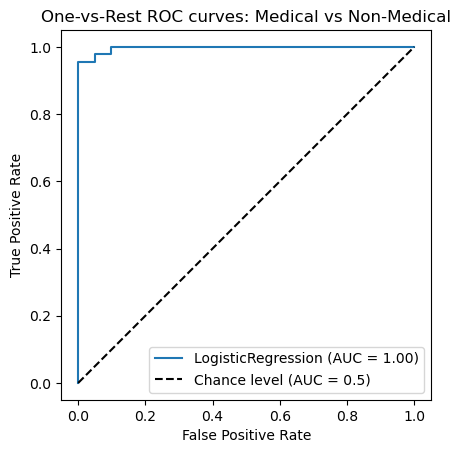

In [10]:
logistic_regressor(validation=True, plot=True)